# Lyapunov exponent estimation of Neuronal activity in C. Elegans
This script computes the Lyapunov spectrum of experimental calcium imaging data of C. Elegans. To do so, the data is first imported and some pre-processing is done. Then state space reconstruction is applied to it and finally the Lyapunov spectrum is computed iteratively.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math as math
import os
import scipy.io
import numpy.ma as ma
import scipy.signal as ss

from tqdm import tqdm 
from scipy import integrate
from scipy.linalg import expm
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from scipy import interpolate
from scipy.signal import find_peaks

## Importing the data and preprocessing

In [2]:
rootdir = 'worms/'
data_paths=[]

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if file.endswith('.mat'):
            data_paths.append(os.path.join(subdir, file))

fullD_tseries_w=[]
frameRate_w=[]
time_w=[]
neuronID_w=[]
wormID_w=[]
#Accessing the data for the different worms
for data_path in data_paths:
    mat=scipy.io.loadmat(data_path)
    fullD_tseries=np.array(mat['wbData']['deltaFOverF_bc'])[0][0]
    time=np.hstack(np.array(mat['wbData']['tv'])[0][0])
    neuron_IDs=np.array(mat['wbData']['NeuronIds'])[0][0]
    wormID=np.array(mat['wbData']['FlNm'])[0][0][0]
    #Identifier of observed worm
    wormID_w.append(wormID)
    #Identifier for the neuron
    neuronID_w.append(neuron_IDs)
    #Measured calcum imaging data
    fullD_tseries_w.append(fullD_tseries)
    #Rate of the imaging
    frameRate_w.append(1/(time[1]-time[0]))
    #Time of image
    time_w.append(time)

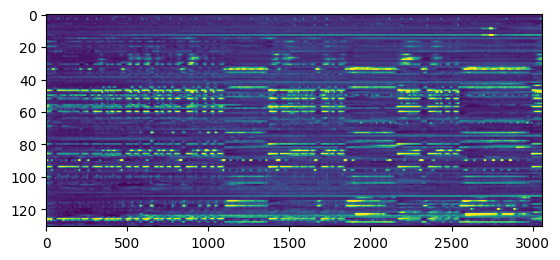

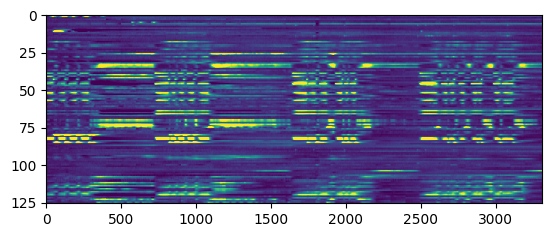

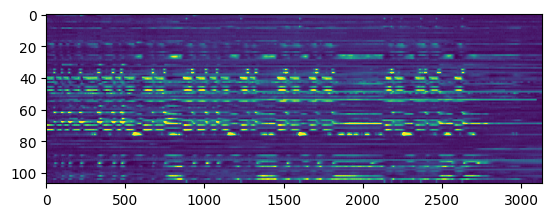

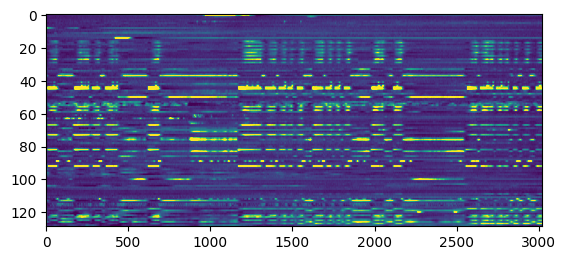

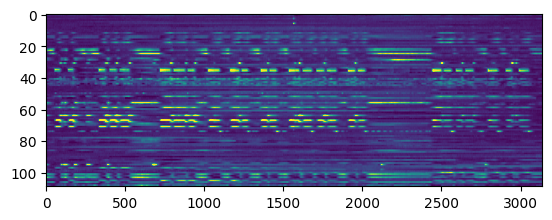

In [3]:
for kw,wormID in enumerate(wormID_w):
    plt.imshow(fullD_tseries_w[kw].T,aspect=10,vmax=1,vmin=0)
    plt.show()

### Find neurons that are common across recordings

In [4]:
#Identifies how often each neuron is active in all of the worms
indices_nID_w = []
for kw in range(len(neuronID_w)):
    indices_nID=[]
    for kn,nID in enumerate(neuronID_w[kw][0]):
        if nID.shape[1]==1:
            if nID[0][0][0][:1] != '-':
                indices_nID.append([kn,nID[0][0][0]])
    indices_nID_w.append(np.vstack(indices_nID))
    
sel_w = []
for kw in range(len(neuronID_w)):
    sel_w.append([nID in indices_nID_w[kw][:,1] for nID in indices_nID_w[2][:,1]])

sel_all = np.logical_and(sel_w[4],np.logical_and(sel_w[3],np.logical_and(sel_w[2],np.logical_and(sel_w[0],sel_w[1]))))
nIDs_all_worms = indices_nID_w[2][sel_all,1]
#Selected neurons
nIDs_all_worms

array(['RMED', 'RMER', 'RMEL', 'RID', 'ALA', 'AVAR', 'AVAL', 'AVER',
       'AIBR', 'AVBL', 'AIBL', 'RIMR', 'RIML', 'VB02', 'VB01'],
      dtype='<U21')

In [5]:
#get time series for commonly recorded neurons
tseries_w=[]
for kw in range(len(sel_w)):
    indices = []
    for nID in nIDs_all_worms:
        idxnID = indices_nID_w[kw][np.where(indices_nID_w[kw][:,1] == nID)[0]][0]
        idx = int(idxnID[0])
        indices.append(idx)
    tseries_w.append(fullD_tseries_w[kw][:,indices])

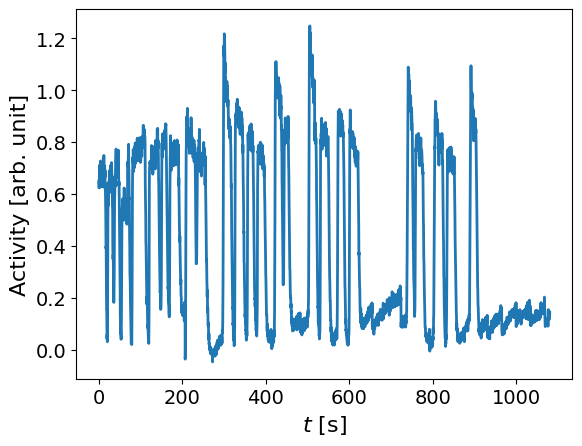

In [6]:
#Activity of AVAR over time for worm 2
fig, ax = plt.subplots()
plt.plot(time_w[2],tseries_w[2][:,5],linewidth=2)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.xlabel(r'$t$ [s]',fontsize=16)
plt.ylabel(r'Activity [arb. unit]',fontsize=16)
#plt.legend(fontsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
fig.savefig('AVAR_activity_worm_2.png', format='png', dpi=600,bbox_inches='tight')
plt.show()


In [ ]:
#Activity of the selected neurons only
for kw,wormID in enumerate(wormID_w):
    plt.imshow(tseries_w[kw].T,aspect=50,vmax=2.,vmin=0)
    plt.show()

### Interpolate to have a common sampling rate across worms
This is necessary in order to be able to have the different time series data "sampled" at the same points in time.

In [7]:
new_frameRate = 2
new_dt = 1/new_frameRate
window_length=5
poly_order=1
interp_tseries_w = []
new_times_w=[]
interp_times_w = []
for kw in range(len(sel_w)):
    x = time_w[kw]
    y = tseries_w[kw]
    f = interpolate.interp1d(x, y,kind='cubic',axis=0)
    xnew = np.arange(0, time_w[kw][-1], new_dt)
    ynew = f(xnew) 
    #added a smoothing step to get rid of some noise
    ynewf = ss.savgol_filter(ynew,window_length,poly_order,axis=0)
    interp_tseries_w.append(ynewf)
    interp_times_w.append(xnew)
    new_times_w.append(xnew)

### Do PCA to reduce dimensionality and further reduce noise
As low variance modes are most likely noise and the real dynamics are captured by the high variance modes, one can do PCA and keep only modes which are associated to the latter ones.

In [8]:
Xw = []
#Puting all the different worms data in the same time series
for kw in range(len(sel_w)):
    ts = interp_tseries_w[kw]
    ts = (ts-ts.mean())/ts.std()
    ts[:1] = ma.masked
    Xw.append(ts)
X_all = ma.vstack(Xw)
#Mask zero values (= no calcium data observed)
X_all[X_all==0] = ma.masked

X =X_all-X_all.mean(axis=0)
cov = ma.cov(X.T)
eigvals,eigvecs = np.linalg.eig(cov)

#Cummulative sum of eigenvalues (i.e. how much variance captuared by the n first eigenvalues)
print(np.cumsum(eigvals)/np.sum(eigvals))

[0.74005811 0.80188791 0.83719109 0.86768499 0.89469024 0.91775273
 0.93785134 0.95476048 0.96563619 0.97509963 0.98386037 0.9888885
 0.99206348 0.99613675 1.        ]


In [9]:
#Project on first five principal directionsx
pca_tseries = X.dot(eigvecs[:,:5])
X_all = pca_tseries

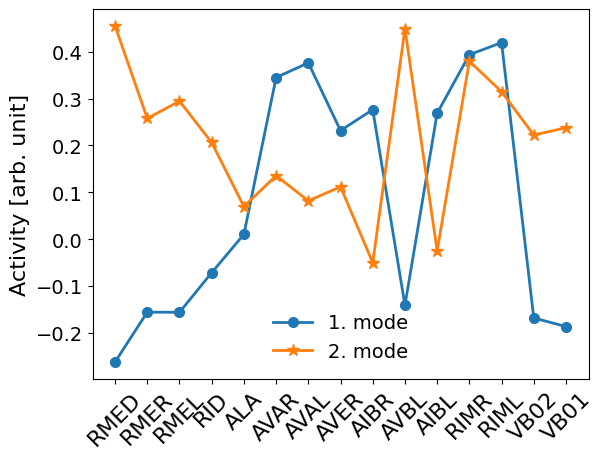

In [8]:
fig, ax = plt.subplots()
plt.plot(eigvecs[:,0],marker='o',markersize=7,linewidth=2,label='1. mode')
plt.plot(eigvecs[:,1],marker='*',markersize=9,linewidth=2,label='2. mode')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.legend(frameon=False,fontsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
plt.ylabel(r'Activity [arb. unit]',fontsize=16)
plt.xticks(range(len(nIDs_all_worms)),nIDs_all_worms,rotation=45,fontsize=16)
fig.savefig('PCA_Modes.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

## Embed time series data 
In this section the data is embedded using the time delay matrix followed by dimensionality reduction using ICA. In order to find the optimal parameters of the embedding, the prediction time is maximized.

### Embedding functions

In [10]:
def segment_maskedArray(tseries,min_size=50):
    '''
    Segments  time series in case it has missing data
    '''
    if ~np.ma.isMaskedArray(tseries):
        tseries = ma.masked_invalid(tseries)
    if len(tseries.shape)>1:
        mask = ~np.any(tseries.mask,axis=1)
    else:
        mask = ~tseries.mask
    segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)
    segs_ = []
    for t0,tf in segments:
        if tf-t0>min_size:
            segs_.append([t0,tf])
    segments = np.vstack(segs_)
    return segments

def tm_seg(X,K):
    '''
    Build a trajectory matrix
    X: N x dim data
    K: the number of delays
    out: (N-K)x(dim*K) dimensional
    '''
    tm=np.zeros(((len(X)-K-1),X.shape[1]*(K+1)))
    for t in range(len(X)-K-1):
        x = X[t:t+K+1,:]
        x_flat = x.flatten()
        tm[t] = x_flat
    return tm

def trajectory_matrix(X,K):
    '''
    This is constructing the lag matrix
    '''
    min_seg=K+1
    segments = segment_maskedArray(X,min_seg)
    traj_matrix = ma.zeros((len(X),X.shape[1]*(K+1)))
    for t0,tf in segments:
        traj_matrix[t0+int(np.floor(K/2)):tf-int(np.ceil(K/2)+1)] = ma.masked_invalid(tm_seg(ma.filled(X[t0:tf],np.nan),K))
    #Mask invalid values
    traj_matrix[traj_matrix==0]=ma.masked
    return traj_matrix

#########################
########Whitening########
#########################

def whitening(X):
    """
    Whitens the input matrix X using specified whitening method.
    Inputs:
        X:      Input data matrix with data examples along the first dimension
    """
    X = X.reshape((-1, np.prod(X.shape[1:])))
    X_mean = np.mean(X,axis=0)
    X_centered = X - X_mean
    Sigma = np.dot(X_centered.T, X_centered) / X_centered.shape[0]
    U, Lambda, V = np.linalg.svd(Sigma)
    W = np.dot(np.diag(1.0 / np.sqrt(Lambda + 1e-5)), U.T) #we add a regularizing term
    #np.dot(X_centered, W.T) is the data projected to the Independen components
    
    """
    #Plotting the captured variance
    eigvals=Lambda
    fig, ax = plt.subplots()
    plt.plot(np.arange(len(eigvals))+1,np.cumsum(eigvals)/np.sum(eigvals),'o',markersize=7,linewidth=2)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    ax.yaxis.get_offset_text().set_fontsize(14)
    plt.xlabel(r'$m$',fontsize=16)
    plt.ylabel(r'Captured variance',fontsize=16)
    fig.savefig('PCA_CapturedVar.png', format='png', dpi=600,bbox_inches='tight')
    plt.show()
    """
    return U,X_mean,W,np.dot(X_centered, W.T)

def whiten_pca(traj_matrix):
    modes,mean_X,transformation,whitened_X = whitening(ma.compress_rows(traj_matrix))
    whitened = ma.zeros(traj_matrix.shape)
    whitened[~np.any(traj_matrix.mask,axis=1)] = whitened_X
    whitened[np.any(traj_matrix.mask,axis=1)] = ma.masked
    return modes,mean_X,transformation,whitened

def invert_transform(phspace,w,xmean):
    m = phspace.shape[1]
    return phspace.dot(np.linalg.pinv(w[:m,:].T))+xmean

### Maximizing prediction time
The prediction time is a measure of the quality of an embedding. The time series is embedded with a given pair of parameters $(K,m)$ and the nearest neighbours of a point are evolved. Averaging the time evolution of the nearest neighbours in the reconstructed space and going back to the observational space, allows to predict the evolution of a point. By comparing this evolved point to the experimental data, one can optimize the choice of $(K,m)$.

#### Auxilary functions to compute $T_{\text{pred}}$:

In [11]:
def linear_fit(x,y):
    reg = LinearRegression().fit(x.reshape(-1,1), y)
    r2 = reg.score(x.reshape(-1,1),y)
    m = reg.coef_[0]
    b = reg.intercept_
    return r2,m,b

def prediction_time(mean_distance,n_iters=20):
    tau0 = np.random.randint(int(len(mean_distance)*.05),int(.95*len(mean_distance)))
    es0=mean_distance[tau0]
    intE = np.cumsum(mean_distance)
    len_dist = len(mean_distance)
    x,y = np.arange(tau0,len(mean_distance)),intE[tau0:len(mean_distance)]
    r2,new_es,new_A = linear_fit(x,y)
    new_tau= np.arange(len(mean_distance))[mean_distance>new_es][0]
    Tpreds = [-new_A/new_es,]
    r2s=[r2,]
    es = [new_es,]
    As = [new_A,]
    for k in range(n_iters):
        x,y = np.arange(new_tau,len(mean_distance)),intE[new_tau:len(mean_distance)]
        r2,new_es,new_A = linear_fit(x,y)
        new_tau= np.arange(len(mean_distance))[mean_distance>new_es][0]
        Tpreds.append(-new_A/new_es)
        if np.abs(new_es-es[-1])<1e-8:
            if np.abs(new_A-As[-1])<1e-8:
                break
        As.append(new_A)
        es.append(new_es)
    return As,es,np.hstack(Tpreds)

def get_indices(sort_index,Np,Lagmat,tmax):
    indices = []
    k=0
    while len(indices)<1:
        idx = sort_index[k]
        if ma.count_masked(Lagmat[idx:idx+tmax])==0:
            indices.append(idx)
        else:
            k+=1
    for idx in sort_index[k:]:
        if np.min(np.abs(np.array(indices)-idx))>50:
            if ma.count_masked(Lagmat[idx:idx+tmax])==0:
                indices.append(idx)
        if len(indices)>=Np:
            break
    return indices[:Np]

def bootstrap(l,n_times,confidence_interval=95):
    '''2sigma Confidence interval using bootsrapping'''
    per=(100-confidence_interval)/2
    new_means=[]
    for i in range(n_times):
        indices=np.random.choice(range(0,len(l)),len(l))
        new_list=[l[idx] for idx in indices]
        new_means.append(ma.mean(new_list,axis=0))
    new_means=ma.vstack(new_means)
    cil=np.zeros(new_means.shape[1])
    ciu=np.zeros(new_means.shape[1])
    for i in range(new_means.shape[1]):
        cil[i]=np.nanpercentile(new_means[:,i].filled(np.nan),per)
        ciu[i]=np.nanpercentile(new_means[:,i].filled(np.nan),100-per)
    cil = ma.masked_array(cil, np.isnan(cil))
    ciu = ma.masked_array(ciu, np.isnan(ciu))
    return ma.mean(l,axis=0),cil,ciu

#### Finding optimal number of nearest neighborus
This code computes the one step prediction error for different values of nearest neighbours. The best results seem to be given for $N_p$=3 or 4, in the following $N_p$=4 is used.

In [ ]:
#Construct the trajectory matrix
tmax=200

K=20
dim=X_all.shape[1]
Lagmat=trajectory_matrix(X_all,K=K-1) 

#Maximal number of nearest neighbours
maxNp=12

#Points to average over
npoints=5000
segments = segment_maskedArray(Lagmat)
all_indices = np.hstack([np.arange(t0,tf-tmax) for t0,tf in segments])
points = np.random.choice(all_indices,npoints,replace=False)

#One step prediction error for each point and number of nearest neighbours
eps_p = ma.zeros((maxNp-1,npoints))

for kp,p0 in enumerate(tqdm(points)):
    #Finding nearest neighbours
    disttoxt=ma.sqrt(ma.sum((Lagmat[:-tmax]-Lagmat[p0])**2,axis=1))
    disttoxt[p0-50:p0+50]=np.Inf #Excluding nearest neighbours in time
    sort_index = ma.argsort(disttoxt) #Keeping only clostest points
    
    for kn,Np in enumerate(np.arange(1,maxNp)):
        NNIndices = get_indices(sort_index,Np,Lagmat,tmax)
        if len(NNIndices)==Np:
            #Average over evolved state of nearest neighbours
            NearNeighbourstnew=[Lagmat[NNIndices[kn]:NNIndices[kn]+tmax] for kn in range(Np)]
            Xpred = ma.masked_invalid(ma.mean(NearNeighbourstnew,axis=0))
            eps_p[kn,kp] = ma.sum(ma.sqrt((Xpred[1,-dim:]-Lagmat[p0+1,-dim:])**2))
        else:
            print('error for {}'.format(Np),flush=True)

#Get errorbars
eps_p[eps_p==0] = ma.masked
mean_eps,cil_eps,ciu_eps = bootstrap(eps_p.T,n_times=100)

In [ ]:
fig, ax = plt.subplots()
plt.errorbar(np.arange(1,maxNp),mean_eps,yerr = [mean_eps-cil_eps,ciu_eps-mean_eps],linewidth=2,capsize=5,fmt='o')
plt.ylabel(r'$E(1)$',fontsize=16)
plt.xlabel(r'$N_p$',fontsize=16)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
fig.savefig('Np_CElegans.png', format='png', dpi=600,bbox_inches='tight')
plt.show()


#### Finding optimal value of $K$

In [ ]:
dt=new_dt
tmax=200
#Optimal number of nearest neighbours found before
Np=4
npoints=5000

#Range of considered values for K
K_range = np.arange(1,40)
Tpred_K = np.zeros((len(K_range),3))
eps_K = np.zeros((len(K_range),npoints,tmax))

for k,K in enumerate(tqdm(K_range)):
    dim=X_all.shape[1]
    #Construct the lag matrix
    Lagmat=trajectory_matrix(X_all,K=K-1)
    segments = segment_maskedArray(Lagmat)
    all_indices = np.hstack([np.arange(t0,tf-tmax) for t0,tf in segments])
    
    #Randomly pick points
    points = np.random.choice(all_indices,npoints,replace=False)
    eps_p = ma.zeros((npoints,tmax))
    
    for kp,p0 in enumerate(points):
        disttoxt=ma.sqrt(ma.sum((Lagmat[:-tmax]-Lagmat[p0])**2,axis=1))
        #Excluding nearest neighbours in time
        disttoxt[p0-50:p0+50]=np.Inf
        
        #Keeping only clostest points
        sort_index = ma.argsort(disttoxt)   
        NNIndices = get_indices(sort_index,Np,Lagmat,tmax)
        
        #Compute prediction error
        if len(NNIndices)==Np:
            NearNeighbourstnew=[Lagmat[NNIndices[kn]:NNIndices[kn]+tmax] for kn in range(Np)]
            Xpred = ma.masked_invalid(ma.mean(NearNeighbourstnew,axis=0))
            eps_p[kp] = ma.sum(ma.sqrt((Xpred[:,-dim:]-Lagmat[p0:p0+tmax,-dim:])**2),axis=1)
    eps_p[eps_p==0]=ma.masked
    
    #Average prediction error over different points
    Etau = eps_p.mean(axis=0)
    
    #Store the resulting error for fixed K
    eps_K[k] = eps_p

    
    #Compute prediction time
    As,es,tps=prediction_time(Etau,n_iters=20)
    mean = tps[-1]*dt

    #Computing 2 sigma confidence intervall using bootstraping
    n_boot = 1000
    Tpred_boot = np.zeros(n_boot)
    for kb in range(n_boot):
        Etau = eps_p[np.random.randint(0,len(eps_p),len(eps_p))].mean(axis=0)
        As,es,tps=prediction_time(Etau,n_iters=20)
        Tpred_boot[kb] = tps[-1]*dt
    cil = np.percentile(Tpred_boot,5)
    ciu = np.percentile(Tpred_boot,95)
    Tpred_K[k] = [mean,cil,ciu]


In [ ]:
fig, ax = plt.subplots()
plt.errorbar(K_range,Tpred_K[:,0],yerr = [Tpred_K[:,0]-Tpred_K[:,1],Tpred_K[:,2]-Tpred_K[:,0]],linewidth=2,capsize=5,fmt='o')
plt.xlabel(r'$K$',fontsize=16)
plt.ylabel(r'$T_{pred}(K)$ [s]',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.yaxis.get_offset_text().set_fontsize(14)
fig.savefig('K_CElegans.png', format='png', dpi=600,bbox_inches='tight')
plt.show()


#### Finding optimal value of $m$


In [11]:
#Parameters found before
K=8
Np=4

mmax=20
dim=X_all.shape[1]
traj_matrix = trajectory_matrix(X_all,K-1)
u,xmean,w,phspace_all = whiten_pca(traj_matrix)
phspace = phspace_all[:,:mmax]

In [13]:
dt=new_dt
dim=X_all.shape[1]
tmax=400
npoints=5000
m_range = np.arange(2,mmax)
Tpred_m = np.zeros((len(m_range),3))
eps_m = np.zeros((len(m_range),npoints,tmax))
for km,m in enumerate(tqdm(m_range)):
    phspace = phspace_all[:,:m]
    segments = segment_maskedArray(phspace)
    all_indices = np.hstack([np.arange(t0,tf-tmax) for t0,tf in segments])
    points = np.random.choice(all_indices,npoints,replace=False)
    eps_p = ma.zeros((npoints,tmax))
    for kp,p0 in enumerate(points):
        disttoxt=ma.sqrt(ma.sum((phspace[:-tmax]-phspace[p0])**2,axis=1))
        #Excluding nearest neighbours in time
        disttoxt[p0-50:p0+50]=np.Inf
        #Keeping only clostest points
        sort_index = ma.argsort(disttoxt)   
        NNIndices = get_indices(sort_index,Np,phspace,tmax)
        if len(NNIndices)==Np:
            NearNeighbourstnew=[phspace[NNIndices[kn]:NNIndices[kn]+tmax] for kn in range(Np)]
            Xpred = ma.masked_invalid(ma.mean(NearNeighbourstnew,axis=0))
            x_traj_pred = invert_transform(Xpred,w,xmean)
            x_traj_data = traj_matrix[p0:p0+tmax]
            eps_p[kp] = ma.sqrt(ma.sum((x_traj_pred[:,-dim:]-x_traj_data[:,-dim:])**2,axis=1))
    eps_p[eps_p==0]=ma.masked
    
    eps_m[km] = eps_p
    Etau = eps_p.mean(axis=0)
    As,es,tps=prediction_time(Etau,n_iters=20)
    mean = tps[-1]*dt

    n_boot = 1000
    Tpred_boot = np.zeros(n_boot)
    for kb in range(n_boot):
        Etau = eps_p[np.random.randint(0,len(eps_p),len(eps_p))].mean(axis=0)
        As,es,tps=prediction_time(Etau,n_iters=20)
        Tpred_boot[kb] = tps[-1]*dt
    cil = np.percentile(Tpred_boot,5)
    ciu = np.percentile(Tpred_boot,95)
    Tpred_m[km] = [mean,cil,ciu]

100%|███████████████████████████████████████████| 18/18 [08:46<00:00, 29.28s/it]


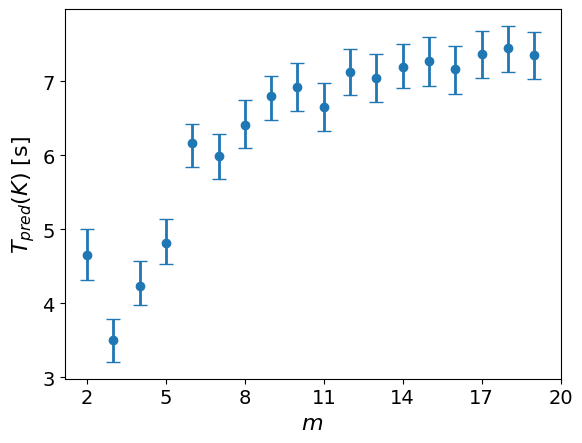

In [14]:
fig, ax = plt.subplots()
plt.errorbar(m_range,Tpred_m[:,0],yerr = [Tpred_m[:,0]-Tpred_m[:,1],Tpred_m[:,2]-Tpred_m[:,0]],linewidth=2,capsize=5,fmt='o')
plt.xlabel(r'$m$',fontsize=16)
plt.ylabel(r'$T_{pred}(m)$ [s]',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(ticks=[2,5,8,11,14,17,20], labels=['2','5','8','11','14','17','20'])
ax.yaxis.get_offset_text().set_fontsize(14)
fig.savefig('m_CElegans.png', format='png', dpi=600,bbox_inches='tight')
plt.show()

## Computing the Lyapunov exponents
Using the embedding created above, one can estimate the Lyapunov spectrum of the system.

### Embedding the data with the above found parameters 

In [13]:
m=6
K=5

dim=X_all.shape[1]
traj_matrix = trajectory_matrix(X_all,K-1)
u,xmean,w,phspace_all = whiten_pca(traj_matrix)
phspace = phspace_all[:,:m]

In [53]:
def norm2one(x):
    ma=np.max(x,axis=0);
    mi=np.min(x,axis=0);
    return (x-mi)/(ma-mi)

def get_epsilon(phspace):
    #Finding average distance after recurrence
    tmax=1000
    rmax=10
    eps_r_t = np.zeros((rmax,tmax))
    t0 = 0 
    for i in range(1,tmax):
        tp =ma.sqrt((phspace[t0:-i]-phspace[t0+i:])**2).sum(axis=1)
        tp = np.sort(tp)
        eps_r_t[:,i] = tp[:rmax]
    #plt.imshow(eps_r_t,aspect=10)
    #plt.show()
    eps_t = np.mean(eps_r_t,axis=0)
    peaks, _ = find_peaks(norm2one(-eps_t), prominence=.1)
    #plt.plot(np.arange(tmax),norm2one(-eps_t))
    #plt.axvline(peaks[0])
    #plt.show()
    return eps_t[peaks[0]]

### Computing the spectrum

In [45]:
def QR_decomp(Matrix):
    '''This fct does QR decomposition of the input matrix 
    and makes sure that the diagonal element of R are positive
    (This is conventional as the QR decomposition is not unique)'''
    Qmat,Rmat = np.linalg.qr(Matrix)
    Rdiag=np.diag(Rmat)
    for k in range(len(Rdiag)):
        if Rdiag[k]<0:
            Rmat[k,:]=-Rmat[k,:]
            Qmat[:,k]=-Qmat[:,k]
    return Qmat,Rmat

def estimate_lyap_exp(Ms,dt,L=1,N=1000):
    dim = Ms[0].shape[1]
    #Global flow
    Flow = np.identity(dim)
    Qhat = np.identity(dim)
    #local Jacobian at point data[0]
    M=Ms[0]
    #Using Q,R decomposition
    Q, R = QR_decomp(M)
    #Storing the Lyapunov exponents
    exponents = np.zeros(len(R))
    exps = []
    for i in (range(1,N)):
        M = Ms[i]
        Flow = np.dot(M,Flow)
        #Compute Lyapunov exponent
        if i % L == 0:
            Flow = np.linalg.multi_dot([Qhat.T, Flow, Qhat])
            Q, R = QR_decomp(Flow)
            exponents=exponents+np.log(np.diag(R))
            #Compute new Qhat
            Qhat = np.dot(Qhat,Q)
            #Reset the flow
            Flow = np.identity(dim)
            exps.append(exponents/(i*dt))
    return np.vstack(exps)


def estimate_discrete_jac(X,epsilon,trange,small_weight_threshold=1e-3,T1=1):
    Ms=ma.zeros((len(trange),X.shape[1],X.shape[1]))
    XX=X[:-T1,:]
    Xn=X[T1:,:]
    for ipred in trange:
        if XX[ipred].mask[0]==True:
            continue
        else:
            sel = np.ones(len(XX),dtype=bool)
            sel[ipred] = False
            dist = ma.sqrt((XX-XX[ipred])**2).sum(axis=1)

            wts = np.exp(-dist/epsilon)
            if ipred<10:
                wts[:ipred]=0
            elif len(wts)-ipred<10:
                wts[-ipred:]=0
            else:
                wts[ipred-10:ipred+10]=0
            wts = ma.masked_invalid(wts)
            wts[dist.mask] = ma.masked

            sel[wts/wts.max()<small_weight_threshold] = False
            sel[dist.mask] = False

            wts = wts[sel]
            z=np.hstack([np.ones(sel.sum()).reshape(-1,1),XX[sel]])
            zw = np.vstack([z[:,m]*wts for m in range(z.shape[1])]).T
            znw =  np.vstack([Xn[sel,m]*wts for m in range(Xn.shape[1])]).T
            A = np.linalg.pinv(zw).dot(znw)
            Ms[ipred] = A[1:].T
    Ms[Ms==0] = ma.masked
    return Ms

In [55]:
def optimize_eps(epsilon,phspace):
    """Optimize epsilon to get a zero exponent"""
    epsrange=np.linspace(0.8*epsmin,1.4*epsmin,50)
    zeroexps=np.zeros(len(epsrange))
    for index,epsilon in (enumerate(epsrange)):
        trange = np.arange(len(phspace)-1)

        #Estimating the flow matrices for points which are not masked
        Ms = estimate_discrete_jac(phspace,epsilon,trange)
        mask = ~phspace[:,0].mask
        #Identifying unmasked sequences
        segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2)

        #Compute the Lyapunov exponents for the unmasked data segments
        exps_seg=[]
        for idx in range(len(segments)):
            t0,tf = segments[idx]
            Ms_sample = Ms[t0:tf]
            exps = estimate_lyap_exp(Ms_sample,new_dt,N=len(Ms_sample))
            exps_seg.append(exps)

        exps_all = np.vstack([exps[-1010:-10] for exps in exps_seg])
        expsAv=exps_all.mean(axis=0)
        zeroexps[index]=np.min(np.abs(expsAv))
    return epsrange[np.where(zeroexps == zeroexps.min())]

## Try different values of $m,K$

/var/folders/nd/69lm7fkj7fb7_431m00p32gr0000gn/T/ipykernel_4958/2907870967.py:32: RuntimeWarning: divide by zero encountered in log
  exponents=exponents+np.log(np.diag(R))


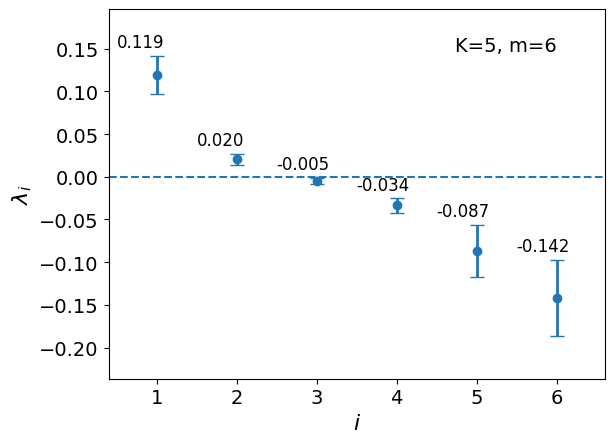

Zero exponents:  0.004755849798011518
Error on exp:  [0.02244919925441506 0.0062264425481437825 0.0038671490667295874
 0.008351950796978789 0.030640135260619577 0.04458372059317614]
Cumulative sum total:  [ 0.11889504  0.13932745  0.1345716   0.10096152  0.01436942 -0.12759384]
Absolute error Cumulative sum total:  [0.02244919925441506 0.028675641802558844 0.032542790869288435
 0.04089474166626722 0.0715348769268868 0.11611859752006294]
Kaplan-Yorke dimension:  5.1659438057537574
Kaplan-Yorke dimension error:  0.6655398748530685


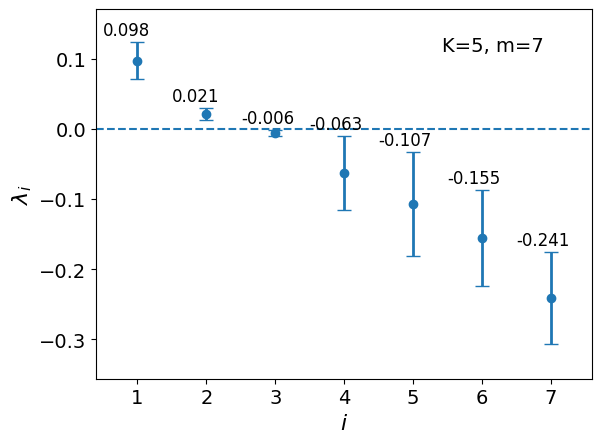

Zero exponents:  0.005643861795330296
Error on exp:  [0.026356492277971284 0.008526498189518044 0.003634006317858936
 0.05286296387547823 0.0743621342679197 0.06859449233061005
 0.06563722883162015]
Cumulative sum total:  [ 0.09753806  0.11896871  0.11332485  0.05013986 -0.05730725 -0.21252248
 -0.45328248]
Absolute error Cumulative sum total:  [0.026356492277971284 0.03488299046748933 0.03851699678534826
 0.09137996066082649 0.1657420949287462 0.23433658725935624
 0.2999738160909764]
Kaplan-Yorke dimension:  4.466646912415307
Kaplan-Yorke dimension error:  0.7981157190884154


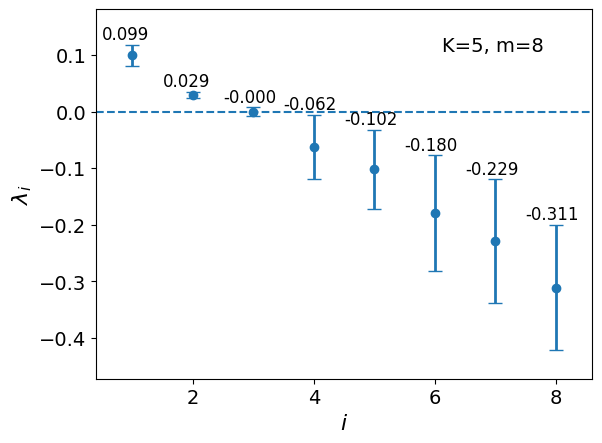

Zero exponents:  0.0002901612813073174
Error on exp:  [0.018433687669917674 0.005575439593680652 0.007689708998696796
 0.056904806858420316 0.07033751871928681 0.10235881905814297
 0.10882281248359901 0.11104930308703062]
Cumulative sum total:  [ 0.09939407  0.12871625  0.12842609  0.06624046 -0.03596293 -0.21578145
 -0.44470939 -0.75590539]
Absolute error Cumulative sum total:  [0.018433687669917674 0.024009127263598325 0.031698836262295124
 0.08860364312071545 0.15894116184000226 0.2612999808981452
 0.37012279338174425 0.4811720964687749]
Kaplan-Yorke dimension:  4.648123933876882
Kaplan-Yorke dimension error:  0.9504182865398269


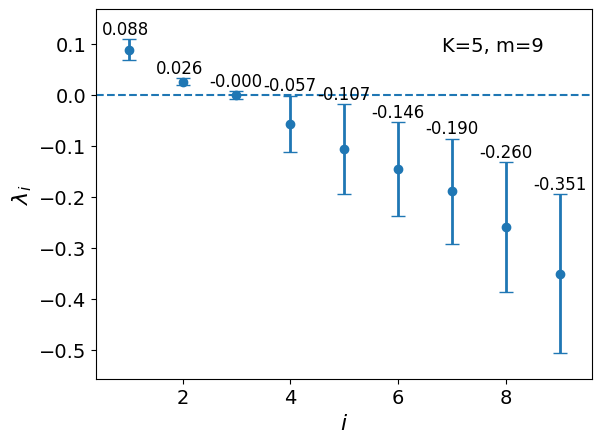

Zero exponents:  0.0004846287817311551
Error on exp:  [0.020753526338122597 0.007286202700741704 0.008078030281279267
 0.05547401039467219 0.08813711967585758 0.09169125445880441
 0.10372520268947781 0.12809544705164722 0.15603354242342837]
Cumulative sum total:  [ 0.08845304  0.11416784  0.11368321  0.05628845 -0.05031304 -0.19646997
 -0.38641097 -0.64615675 -0.99736715]
Absolute error Cumulative sum total:  [0.020753526338122597 0.0280397290388643 0.036117759320143564
 0.09159176971481575 0.17972888939067333 0.27142014384947777
 0.3751453465389556 0.5032407935906028 0.6592743360140312]
Kaplan-Yorke dimension:  4.52802687079836
Kaplan-Yorke dimension error:  0.9169318179233438


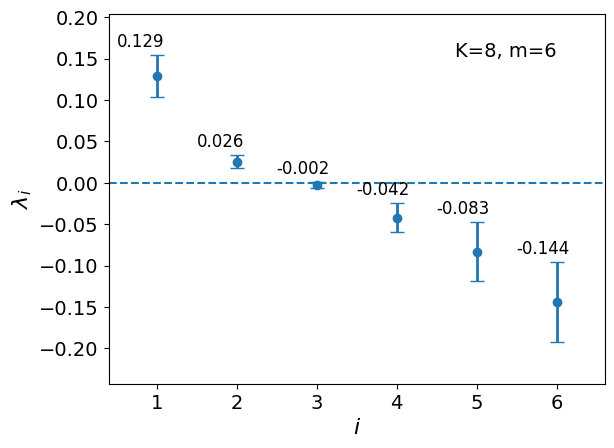

Zero exponents:  0.0023916071744918095
Error on exp:  [0.0254945292045573 0.00829345272107164 0.0037194362150017347
 0.017735547124052082 0.035705660020480166 0.04868635853136934]
Cumulative sum total:  [ 0.12930466  0.15499381  0.15260221  0.11039651  0.02731895 -0.11676002]
Absolute error Cumulative sum total:  [0.0254945292045573 0.03378798192562894 0.037507418140630674
 0.05524296526468275 0.09094862528516293 0.13963498381653228]
Kaplan-Yorke dimension:  5.328836720887403
Kaplan-Yorke dimension error:  0.7460198340361935


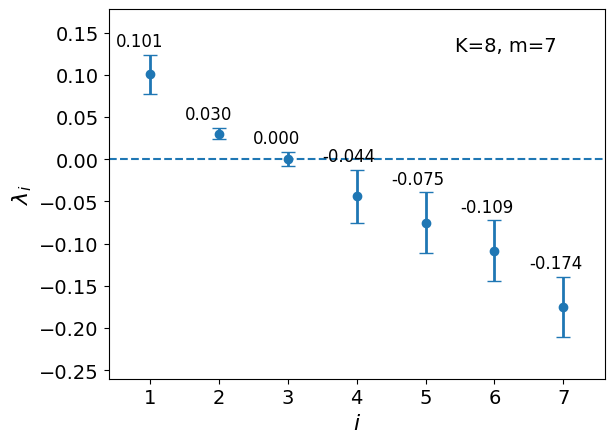

Zero exponents:  0.0001818379562251997
Error on exp:  [0.022947574528298778 0.006884508726862412 0.008294326186911985
 0.03185247791993861 0.036032791728217196 0.03610037434253799
 0.035455000383532616]
Cumulative sum total:  [ 0.10068922  0.13103745  0.13121929  0.08715293  0.01208878 -0.09649631
 -0.27099249]
Absolute error Cumulative sum total:  [0.022947574528298778 0.02983208325516119 0.03812640944207318
 0.06997888736201179 0.10601167909022899 0.14211205343276698
 0.17756705381629959]
Kaplan-Yorke dimension:  5.16104605871326
Kaplan-Yorke dimension error:  0.9848221526065553


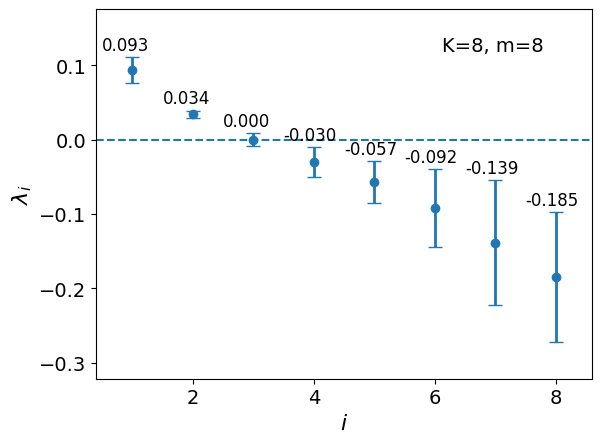

Zero exponents:  6.042712291984947e-05
Error on exp:  [0.017585987270090732 0.004591841282994695 0.00881394259380434
 0.01982218168736501 0.02825846418638168 0.05213888549652903
 0.08418632684391826 0.08704609697860999]
Cumulative sum total:  [ 0.09348135  0.12790241  0.12796284  0.09822828  0.04079657 -0.05133831
 -0.19012897 -0.37483705]
Absolute error Cumulative sum total:  [0.017585987270090732 0.02217782855308543 0.03099177114688977
 0.05081395283425478 0.07907241702063646 0.13121130251716548
 0.21539762936108375 0.30244372633969374]
Kaplan-Yorke dimension:  5.710349167772806
Kaplan-Yorke dimension error:  1.169169440543148


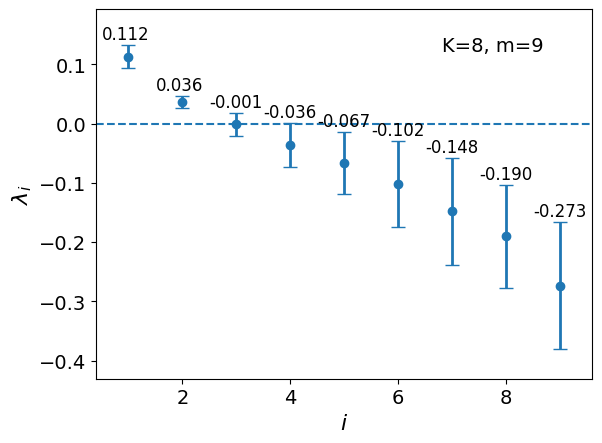

Zero exponents:  0.0011751003673503193
Error on exp:  [0.01939864522721125 0.010404358719092262 0.019430081479311523
 0.03686023532696914 0.05271145506018843 0.07239086760988045
 0.08988255193534281 0.08663044653890883 0.107050496096283]
Cumulative sum total:  [ 0.11246744  0.14874202  0.14756692  0.11138627  0.04448805 -0.05714201
 -0.20517518 -0.39561915 -0.66903508]
Absolute error Cumulative sum total:  [0.01939864522721125 0.02980300394630351 0.04923308542561503
 0.08609332075258416 0.1388047758127726 0.21119564342265304
 0.30107819535799585 0.3877086418969047 0.4947591379931877]
Kaplan-Yorke dimension:  5.665010935588408
Kaplan-Yorke dimension error:  1.8432744387581075


In [56]:
for K in [5,8]:
    for m in [6,7,8,9]:
        #Embedd
        dim=X_all.shape[1]
        traj_matrix = trajectory_matrix(X_all,K-1)
        u,xmean,w,phspace_all = whiten_pca(traj_matrix)
        phspace = phspace_all[:,:m]
        
        #optimize epsilon
        epsmin=get_epsilon(phspace)
        epsilon=optimize_eps(epsmin,phspace)
        #Get Jacobian
        trange = np.arange(len(phspace)-1);
        #Estimating the flow matrices for points which are not masked
        Ms = estimate_discrete_jac(phspace,epsilon,trange);
        mask = ~phspace[:,0].mask;
        #Identifying unmasked sequences
        segments = np.where(np.abs(np.diff(np.concatenate([[False], mask, [False]]))))[0].reshape(-1, 2);

        #Compute the Lyapunov exponents for the unmasked data segments
        exps_seg=[]
        for idx in range(len(segments)):
            t0,tf = segments[idx]
            Ms_sample = Ms[t0:tf]
            exps = estimate_lyap_exp(Ms_sample,new_dt,N=len(Ms_sample))
            exps_seg.append(exps)

        #Putting all the estimates together
        exps_all = np.vstack([exps[-1010:-10] for exps in exps_seg])
        #Average over the last 1000 iterations for each segment (average over 5000 estimations for each exponent)
        expsAv=exps_all.mean(axis=0)
        errorbar=exps_all.std(axis=0)
        fig, ax = plt.subplots()
        plt.errorbar(np.arange(m)+1,expsAv,yerr = errorbar,linewidth=2,capsize=5,fmt='o')
        for i,lambdai in enumerate(expsAv):
            plt.text(i+0.5,lambdai+errorbar[i]+0.01,str("{:.3f}".format(lambdai)),fontsize=12)

        plt.xlabel(r'$i$',fontsize=16)
        plt.ylabel(r'$\lambda_i$',fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.tick_params(axis='both', which='minor', labelsize=12)
        ax.set_xlim([0.4,i+1.6])
        ax.set_ylim([expsAv[-1]-errorbar[-1]-0.05,expsAv[0]-errorbar[0]+0.1])
        plt.text(0.8, 0.9,r'K='+str(K)+', m='+str(m),fontsize=14,horizontalalignment='center',verticalalignment='center',transform = ax.transAxes)

        ax.yaxis.get_offset_text().set_fontsize(14)
        plt.axhline(0,ls='--')
        fig.savefig('LyapunovSpectrum_CElegans_m='+str(m)+'_K='+str(K)+'.png', format='png', dpi=600,bbox_inches='tight')
        plt.show()
        
        print("Zero exponents: ",np.min(np.abs(expsAv)))  
        print("Error on exp: ",errorbar)              
        cumsum=expsAv.cumsum()
        print("Cumulative sum total: ",cumsum)
        print("Absolute error Cumulative sum total: ",np.abs(errorbar.cumsum()))
        dim=4+cumsum[3]/np.abs(expsAv[4])
        print("Kaplan-Yorke dimension: ",dim)
        Expscumall=exps_all.cumsum(axis=1)
        dimerror=(Expscumall[:,3]/np.abs(exps_all[:,4])).std(axis=0)
        print("Kaplan-Yorke dimension error: ",dimerror)